$
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{bra}[1]{\langle#1\vert}
$

# Ground-state energy of $H_2$ with Qiskit

- [1. The VQE algorithm: What is and why is used?](#sec1)

- [2. Creating a parameterized wavefunction $\Psi(\vec{\theta})$: an intuitive ansatz](#sec2)
   - [A Coupled-Cluster ansatz](#sec2a)
   - [An (intuitive) ad hoc ansatz](#sec2b)
   - [Test the effect of the ansatz's circuit on quantum states](#sec2c)
   - [Test the $H_2$ energies produced by the ansatz](#sec2d)

- [3. Evaluating the minimum energy $E = \bra{\Psi(\vec{\theta})} \hat{h} \ket{\Psi(\vec{\theta})}$ with VQE](#sec3)

- [4. Comparing the performance of different ansatzes](#sec4)

- [5. References](#sec5)

<a id='sec1'></a>
## 1. The VQE algorithm: What is and why is used?

The prototypical quantum algorithm to solve this problem is QPE (Quantum Phase Estimation); however, current quantum computers are not yet capable of running it. We resort to the more practical VQE (Variational Quantum Eigensolver) algorithm, which is a temporary solution designed for the modest specifications of the currently available quantum computers. VQE is a hybrid algorithm (quantum + classical) which reduces the load of the quantum computations (steps 1 and 3) by off-loading some work to a classical computer (steps 2 and 4). The steps are:

 1. Creating a parameterized wavefunction $\Psi(\vec{\theta})$, aka the ansatz.
 2. Choose/update the set of parameters $\vec{\theta}$ using any classical minimization method (e.g. conjugate gradient).
 3. Evaluating the minimum energy $E = \bra{\Psi(\vec{\theta})} \hat{h} \ket{\Psi(\vec{\theta})}$ with VQE.
 4. If $E$ is converged: exit, otherwise loop back to step 2.


<a id='sec2'></a>
## 2. Creating a parameterized wavefunction $\Psi(\vec{\theta})$: an intuitive ansatz

Here we create a molecular wavefunction and map it onto a quantum circuit. One can choose any *reasonable* method for constructing a parameterized wavefunction (i.e. the ansatz), but the accuracy and speed of the calculation strongly depend on the quality of the ansatz.

<a id='sec2a'></a>
### 2.1 A Coupled-Cluster ansatz
Naturally, one first resort to the way it's done in Coupled Cluster (with a small modification to make it unitary) in which a parameterized expansion results from the application of cluster operator $\hat{T}$ to the reference Hartree-Fock (HF) state. 

$$
\ket{\Psi(\vec{\theta})} = e^{\hat{T}} \ket{\Psi_{HF}}
$$

where $\hat{T} = \sum_i \hat{T}_i$. 

The CC ansatz produces wavefunctions as a linear combination of several Slater determinants, corresponding to no excitations (the Hartree-Fock state), single excitations, double excitations, etc. In doing so the coefficients in the linear combination are  the set of parameters in the vector $\theta$, which are to be found. For example, the operators for single $\hat{T}_1$ and double $\hat{T}_2$ excitations are

$$
\hat{T}_1 = \sum_{i \in \mathrm{occ}; a \in \mathrm{virt}} \theta_{i,a} \hat{a}^\dagger_a \hat{a}_{i} \\
\hat{T}_2 = \sum_{i,j \in \mathrm{occ}; a,b \in \mathrm{virt}} \theta_{ij,ab} \hat{a}^\dagger_a \hat{a}^\dagger_b \hat{a}_{i}\hat{a}_{j}.
$$  


<a id='sec2b'></a>
### 2.2 An (intuitive) ad hoc ansatz

As depicted in figure below, ket $\ket{0101}$ represents a wavefunction with no excitations (i.e. the HF state) and $\ket{1010}$ a doubly-excited state. Notice the particular ordering in mapping energy levels ($i, j, a, b$) to the qubits ($b, j, a, i$). This follows from the convention in Qiskit where all $\uparrow$ spin orbitals ($i, a$) go before before the $\downarrow$ spin orbitals ($j, b$). 

<p align="middle">
<img src="figures/pic1.png" width="400" />
</p>

Before trying the Coupled-Cluster ansatz, we'll show a simpler yet more intuitive ansatz which employs only one parameter $\theta$. First, how to map a wavefunction into a quantum circuit? The short answer is that in the second-quantization representation of quantum chemistry (aka number representation) a wavefunction ends up looking like something rather representable by a register of qubits (more so if we use the Jordan-Wigner mapping).

Our ad hoc ansatz is as a linear combination of a HF and a doubly-excitated wavefunctions $\Psi(\theta) =  \cos(\theta)\ket{0101} + \sin(\theta) \ket{1010}$; notice that the choice of coefficients satisfies normalization to 1. In other words, we need to find a parameterized quantum circuit that can produce that state by application of a unitary operator $\hat{U}$.

<p align="middle">
<img src="figures/pic2.png" width="400" />
</p>

$$
\hat{U}(\theta)\ket{0101} =  \cos(\theta)\ket{0101} + \sin(\theta) \ket{1010}
$$

For chemical applications, $\hat{U}$ needs to comply with physical restrictions implicit to a molecular system, i.e., particle and spin conservation: an $\uparrow$ ($\downarrow$) electron can only jump into an $\uparrow$ ($\downarrow$) spin orbital. Reference [Anselmetti2021] presents a quantum circuit that satisfies those requirements. Our Qiskit implementation in is given in file `h2_utils.py` and drawn below. Notice that qubit lines $q_1$ and $q_2$ are interchanged with respect to the paper because Qiskit's Jordan-Wigner mapping uses a different convention to label the spin orbitals (first all $\uparrow$ orbitals then all the $\downarrow$ ones, as mentioned above.)

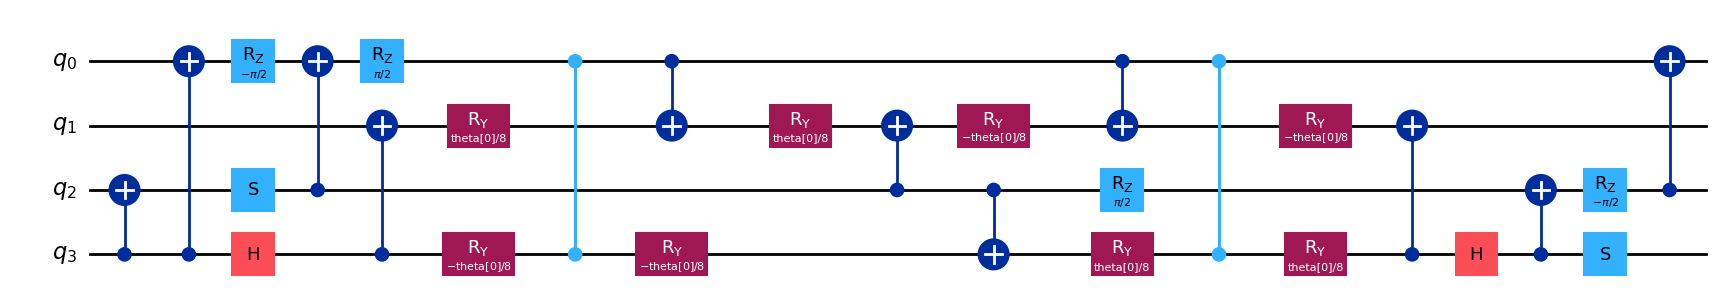

In [1]:
import h2_utils
circuit = h2_utils.double_excitation_circuit()
circuit.draw("mpl")

<a id='sec2c'></a>
### 2.3 Test the effect of the ansatz's circuit on quantum states

Here we evaluate the output states of the circuit for all possible input states. As seen below, we verify that it correctly produces double excitations for the only two cases where it is physically allowed, for all other cases the input states are left unchanged.

In [2]:
import numpy
from qiskit.quantum_info import Statevector
from qiskit.visualization.state_visualization import _state_to_latex_ket

qc = h2_utils.double_excitation_circuit()
theta = 1.04729 #pi/3
bound_qc = qc.assign_parameters([theta])

for i in range(15):
    state_in = Statevector.from_int(i, 2**4)
    state_out = state_in.evolve(bound_qc)
    z= _state_to_latex_ket(state_out).replace("\\rangle",">")
    ibinary = numpy.binary_repr(i, width=4)
    print(f"|{ibinary}> --> {z}")
                    

|0000> -->  |0000>
|0001> -->  |0001>
|0010> -->  |0010>
|0011> -->  |0011>
|0100> -->  |0100>
|0101> --> 0.8660022907 |0101>+0.500040031 |1010>
|0110> -->  |0110>
|0111> -->  |0111>
|1000> -->  |1000>
|1001> -->  |1001>
|1010> --> -0.500040031 |0101>+0.8660022907 |1010>
|1011> -->  |1011>
|1100> -->  |1100>
|1101> -->  |1101>
|1110> -->  |1110>


<a id='sec2c'></a>
### 2.4 Test the $H_2$ energies produced by the ansatz

Here we use the ansatz to calculate the energy of $H_2$ for 50 values of $\theta = [-\pi, \pi]$. That is, we verify a smooth dependence between parameter $\theta$ and the expectation value $E = \bra{\Psi(\theta)} \hat{h} \ket{\Psi(\theta)}$; we observe that the minimum energy is for parameter $\theta \approx -0.2$ rads.

Text(0, 0.5, 'Total energy (Ha)')

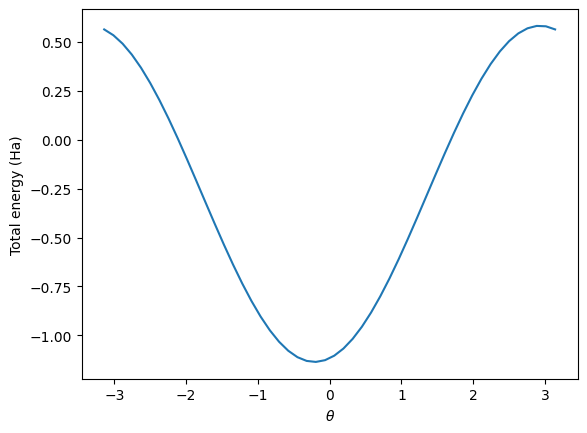

In [3]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import Estimator as Estimator_aer
from qiskit.primitives import Estimator as Estimator
from qiskit_nature.units import DistanceUnit 
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper

molecule = 'H 0.0 0.0 -0.6614; H 0.0 0.0 0.6614'

driver = PySCFDriver(molecule,
                     basis="sto3g",
                     unit=DistanceUnit.BOHR
                     )
electronic_structure = driver.run()

num_spatial_orbitals = electronic_structure.num_spatial_orbitals
num_particles = electronic_structure.num_particles
qubit_mapper = JordanWignerMapper()
qubit_operator = qubit_mapper.map(electronic_structure.second_q_ops()[0])

initial_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                            num_particles=num_particles,
                            qubit_mapper=qubit_mapper,
                            )
ansatz_adhoc = QuantumCircuit.from_instructions(initial_state.data, qubits=initial_state.qubits)
ansatz_adhoc.append(h2_utils.double_excitation_circuit(), [0, 1, 2, 3])
qubit_operator = qubit_mapper.map(electronic_structure.second_q_ops()[0])

thetas = numpy.linspace(-numpy.pi, numpy.pi, 50)
expectation_values = []
for theta in thetas:
    ansatz_adhoc_bound = ansatz_adhoc.assign_parameters([theta])
    expectation_values.append(Estimator_aer(approximation=True).run(ansatz_adhoc_bound, qubit_operator).result().values)

E_nn = 0.755972180224

import matplotlib.pyplot as plt
plt.plot(thetas, numpy.array(expectation_values) + E_nn)
plt.xlabel(r'$\theta$')
plt.ylabel('Total energy (Ha)')

<a id='sec3'></a>
## 3. Evaluating the minimum energy $E = \bra{\Psi(\vec{\theta})} \hat{h} \ket{\Psi(\vec{\theta})}$ with VQE

So far we found that the ground-state energy is for $\theta \approx -0.2$ rads. Now we use gradient descent (from scipy) to pinpoint the precise value of $\theta$ that minimizes the energy curve shown above. We find that the optimal parameter, VQE ground-state energy, and the *exact* ground-state energy 
```
'optimal_point': array([-0.21185821]) 
VQE energy -1.1361872206497723 Ha
Exact energy -1.136189162401985 Ha
```
respectively. Yes, for this small system we are able to find the ground-state energy using an *exact* method instead of having to resort to VQE, but in general that is not possible.

In [4]:
import qiskit_algorithms.optimizers as optimizers
from qiskit_aer.primitives import Estimator as Estimator_aer
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import Estimator as Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit 
#from qiskit_nature.second_q.algorithms import GroundStateEigensolver 

molecule = "H 0.0 0.0 -0.6614; H 0.0 0.0 0.6614"
driver = PySCFDriver(molecule,
                     basis="sto3g",
                     unit=DistanceUnit.BOHR
                     )
electronic_structure = driver.run()

num_spatial_orbitals = electronic_structure.num_spatial_orbitals
num_particles = electronic_structure.num_particles

qubit_mapper = JordanWignerMapper()
qubit_operator = qubit_mapper.map(electronic_structure.second_q_ops()[0])

optimizer = optimizers.GradientDescent(maxiter=500, tol=1e-10) #learning_rate=0.0001)

initial_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                            num_particles=num_particles,
                            qubit_mapper=qubit_mapper,
                            )
ansatz_adhoc = QuantumCircuit.from_instructions(initial_state.data, qubits=initial_state.qubits)
ansatz_adhoc.append(h2_utils.double_excitation_circuit(), [0, 1, 2, 3])

vqe_solver = VQE(estimator=Estimator_aer(approximation=True),
                 ansatz=ansatz_adhoc,
                 optimizer=optimizer,
                 initial_point=[0] * ansatz_adhoc.num_parameters,
                 )

vqe_calculation = vqe_solver.compute_minimum_eigenvalue(qubit_operator)
vqe_energy = electronic_structure.interpret(vqe_calculation).total_energies[0].real

exact_calculation = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_operator)
exact_energy = electronic_structure.interpret(exact_calculation).total_energies[0].real

print(f"VQE energy {vqe_energy} Ha")
print(f"Exact energy {exact_energy} Ha")
print(vqe_calculation)
#calc = GroundStateEigensolver(qubit_mapper, vqe_solver) 
#res = calc.solve(electronic_structure)
#print(res)

VQE energy -1.1361872206497725 Ha
Exact energy -1.1361891624019855 Ha
{   'aux_operators_evaluated': None,
    'cost_function_evals': 1000,
    'eigenvalue': np.float64(-1.8921594008735403),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1303589b0>,
    'optimal_parameters': {   ParameterVectorElement(theta[0]): np.float64(-0.2118582061786196)},
    'optimal_point': array([-0.21185821]),
    'optimal_value': np.float64(-1.8921594008735403),
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x128167e00>,
    'optimizer_time': 2.060361862182617}


<a id='sec4'></a>
## 4. Comparing the performance of different ansatzes

In [5]:
import time
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.circuit.library import UCC

ansatz_ucc_s = UCC(num_spatial_orbitals=num_spatial_orbitals,
                 num_particles=num_particles,
                 excitations='s',
                 qubit_mapper=qubit_mapper,
                 initial_state=initial_state,
                 )

ansatz_ucc_d = UCC(num_spatial_orbitals=num_spatial_orbitals,
                 num_particles=num_particles,
                 excitations='d',
                 qubit_mapper=qubit_mapper,
                 initial_state=initial_state,
                 )
ansatz_ucc_sd = UCC(num_spatial_orbitals=num_spatial_orbitals,
                 num_particles=num_particles,
                 excitations='sd',
                 qubit_mapper=qubit_mapper,
                 initial_state=initial_state,
                 )

#ansatz_uccsd = UCCSD(num_spatial_orbitals=num_spatial_orbitals,
#                 num_particles=num_particles,
#                 qubit_mapper=qubit_mapper,
#                 initial_state=initial_state,
#                 )

twolocal = TwoLocal(4, rotation_blocks='ry', entanglement_blocks='cx', entanglement='linear', reps=4)
ansatz_adhoc2 = QuantumCircuit.from_instructions(initial_state.data, qubits=initial_state.qubits)
ansatz_adhoc2.append(twolocal, [0, 1, 2, 3])

ansatz_list = [ansatz_adhoc, ansatz_ucc_s, ansatz_ucc_d, ansatz_ucc_sd, ansatz_adhoc2]
ansatz_names = ['Ad hoc (physical intuition)', 'UCC singles', 'UCC doubles', 'UCC singles and doubles', 'Ad hoc (just trial&error)']
ansatz_num_parameters = []
vqe_energies = []
vqe_elapsed_times = []
for ansatz in ansatz_list:
    tic = time.time()
    vqe_solver = VQE(estimator=Estimator_aer(approximation=True),
                     ansatz=ansatz,
                     optimizer=optimizer,
                     initial_point=[0] * ansatz.num_parameters,
                     )
    
    ansatz_num_parameters.append(ansatz.num_parameters)
    vqe_calculation = vqe_solver.compute_minimum_eigenvalue(qubit_operator)
    vqe_elapsed_times.append(round(time.time() - tic, 2)) 
    vqe_energies.append(electronic_structure.interpret(vqe_calculation).total_energies[0].real)


In [6]:
from qiskit import transpile
from qiskit_aer import Aer
ansatz_depths = []
backend = Aer.get_backend('qasm_simulator')

for ansatz in ansatz_list:
    ansatz_depths.append(transpile(ansatz, backend=backend).depth())

from IPython.display import display, HTML
import pandas as pd
table = pd.DataFrame(
    {'Ansatz': ['Exact'] + ansatz_names,
     'Total energy (Ha)': [exact_energy] + vqe_energies,
     'Number of layers': ['--'] + ansatz_depths,
     'Number of parameters': ['--'] + ansatz_num_parameters,
     'Elapsed time (s)': ['--'] + vqe_elapsed_times,
    })

display(HTML(table.to_html()))

,Ansatz,Total energy (Ha),Number of layers,Number of parameters,Elapsed time (s)
0,Exact,-1.136189,--,--,--
1,Ad hoc (physical intuition),-1.136187,19,1,2.13
2,UCC singles,-1.117320,9,2,3.49
3,UCC doubles,-1.136146,65,1,4.56
4,UCC singles and doubles,-1.136111,73,3,9.31
5,Ad hoc (just trial&error),-1.136111,15,20,23.95


The circuit for the *ad hoc (physical intuition)* ansatz was shown in Section 2.3. Here, we also show the circuit for the *ad hoc (trial&error)*` ansatz. It's a small circuit (only 15 layers) and gives the same energy as UCC(s,d) but it employs a large number of parameters (20 vs. 1). This ansatz is more than just trial and error; it exemplifies a new research direction ([Kandala2017]) aiming at producing ansatzes in a systematic fashion, which is especially needed for real-world applications in which coming up with physical intuition is not always possible.

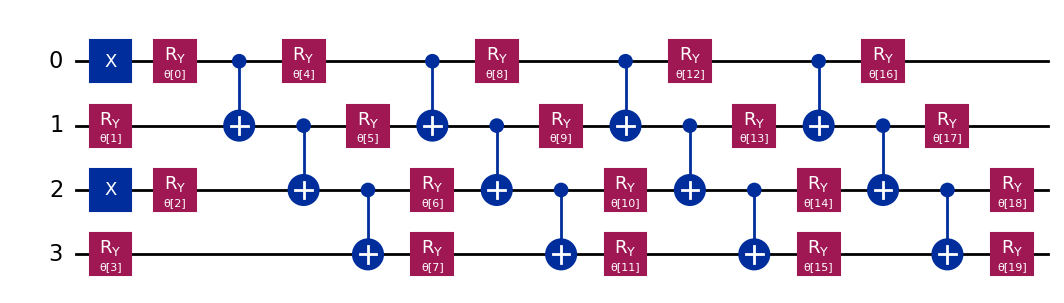

In [7]:
transpile(ansatz_list[-1], backend=backend).draw("mpl")

In [8]:
!pip list | grep "notebook"
!pip list | grep "qiskit"
!python --version

notebook                          7.2.2
notebook_shim                     0.2.4
qiskit                            1.2.4
qiskit-aer                        0.15.1
qiskit-algorithms                 0.3.1
qiskit-ibm-provider               0.11.0
qiskit-ibm-runtime                0.31.0
qiskit-nature                     0.7.2
Python 3.13.0


<a id='sec5'></a>
## 5. References

[Kandala2017] Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets, Nature 549 (7671), 2017.

[Anselmetti2021] Local, expressive, quantum-number-preserving VQE ansätze for fermionic systems, New Journal of Physics 23 (11), 2021.
